<a href="https://colab.research.google.com/github/dbgks25/algorithm-study/blob/main/Nifty_50_Stock_Market_Data(2000_2021)_buy_sell_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주식시장 예측
NIFTY 50 지수에 포함된 50개 종목의 가격 내역과 거래량
모든 데이터 세트는 일 단위, 각 주식에 대한 가격 및 거래 값이 각 주식에 대한 csv파일과 주식 자체에 대한 일부 매크로 정보 포함

In [ ]:
# 시계열 분석
# 주식 가격 시계열 분석에는 어떤 데이터가 필요할까?
# 일단 데이터를 하나 까볼까?


In [ ]:
# 주식 예측 한 걸 확대해보면
# 28일의 주식 가격 어떻게 될 거 같냐 할 때 27일이랑 같다. 라고 답이 변한다
# 왜 이런 현상이 나올까
# loss값 최소화 -> (예측값 - 실제값)
# 이런 최소화할 때 내일 주식가격은 오늘주식가격과 똑같을 것이다
# 가 가장 로스가 낮음 - 쓸데없죠

### 해결책
# 1. 주식 가격을 sequence 데이터로 lstm에 집어넣는 게 맞는지 고민
# 1~10일 주식 가격이랑 11일 주식 가격이 연관성이 있나?
# 다른 게 더 높을 수 있다 영향이
# 주식가격은 랜덤성이 짙어서 예측할 수 없다
# 모든 주식관련 정보가 주식가격에 선반영이 되어 있다

# 2. 가격이 아니라 다른 결과 보는 모델이라면?
# 수익률로 본다면, 20일간 추이를 집어놓고 다음날의 가격이 아니라 다음날 주식을
# 사는 게 맞는지 파는 게 맞는지 예측 -> sequential의 컨닝을 막을 수 있지 않을까

# 3. 가격 말고 다른 요인을 넣는 거는?
# 전날 거래량, SNS 언급량, 전날 나스닥지수 증감량, 관련 업종 증가추이 등 여러 요소가있다.
# 복잡한 레이어를 구성하고 싶으면 Functional API(what?)를 쓰거나,
# feature column(이게 뭘까?)을 이용하면 인풋이 몇 개든 몇 종류든 쉽게 집어넣을 수 있다

# 4. stationary 된 데이터를 사용하자
# 주식가격은 시계열 데이터이다.
# 예측모델을 만들고 싶을 땐 이 데이터가 stationary(평균, 분산, 공분산이 비교적 일정한 데이) 데이터인지 확인해야 함
# 이게 아니면 너무 무작위라 예측모델을 애초에 만들 수가 없다 판단
# 예를 들어 일별 주식가격 변화량으로 바꾸는 것
### 이걸 따지면 주식가격 말고 다른 가격 변화량도 보면 좋다
# stationary인게 검증하려면 Dickey-Fuller 검증이란 것도 있음

# 5. sequential 컨닝을 막을 거면, transformer 모델 쓰면 되지 않나??
# 도전할 필요도 있다..!!




In [1]:
import pandas as pd

In [2]:
df_adaniports = pd.read_csv("ADANIPORTS.csv")

In [24]:
df_adaniports.columns

Index(['Date', 'Close', 'Return', 'Signal'], dtype='object')

In [4]:
df = pd.read_csv("ADANIPORTS.csv")
# symbol에 따라 그룹화
grouped = df.groupby('Symbol')

# 예시로 ADANIPORTS 데이터 선택
df_adaniports = grouped.get_group('ADANIPORTS')

# 필요한 열 선택
df_adaniports = df_adaniports[['Date', 'Close']]

# 날짜 형식 변환 및 정렬
df_adaniports['Date'] = pd.to_datetime(df_adaniports['Date'])
df_adaniports = df_adaniports.sort_values('Date')

# 데이터 확인
print(df_adaniports.head())

           Date   Close
1023 2012-01-17  140.00
1024 2012-01-18  141.70
1025 2012-01-19  149.40
1026 2012-01-20  155.40
1027 2012-01-23  146.75


<Axes: >

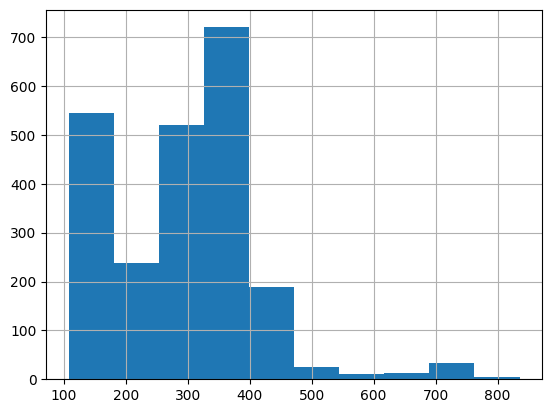

In [7]:
df_adaniports['Close'].hist()

In [8]:
# 수익률 계산
df_adaniports['Return'] = df_adaniports['Close'].pct_change()

In [11]:
# 결측치 제거
df_adaniports = df_adaniports.dropna()

<Axes: >

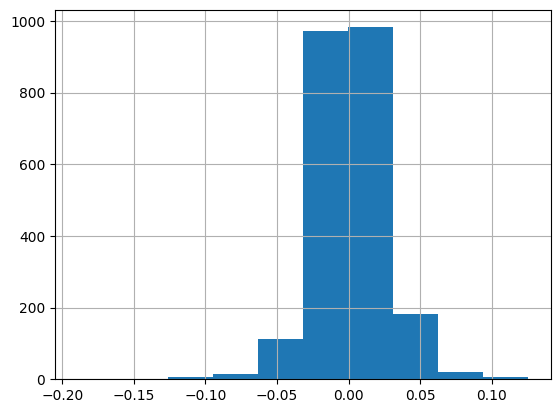

In [12]:
df_adaniports['Return'].hist()

In [13]:
# Return이 stationary인지 확인
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_adaniports['Return'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
"""
ADF Statistic: -50.150792
p-value: 0.000000

ADF 통계량이 음수일수록 데이터가 정상성 가짐
pvalue가 0.05보다 작기 때문에 귀무가설(데이터가 비정상성)을 기각하고, 데이터가 정상성을 가짐

만약, 정상성을 가지지 않는다면, 차분(differencing)을 통해 정상성을 만들 수 있다.

"""

ADF Statistic: -50.150792
p-value: 0.000000


In [14]:
# 수익률 기반 매수/매도 신호 생성 (수익률이 0보다 크면 1(매수), 아니면 0(매도))
df_adaniports['Signal'] = df_adaniports['Return'].apply(lambda x: 1 if x > 0 else 0)

# 결측치 제거
df_adaniports = df_adaniports.dropna()


<ipython-input-14-6955fcfc515f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adaniports['Signal'] = df_adaniports['Return'].apply(lambda x: 1 if x > 0 else 0)


<Axes: >

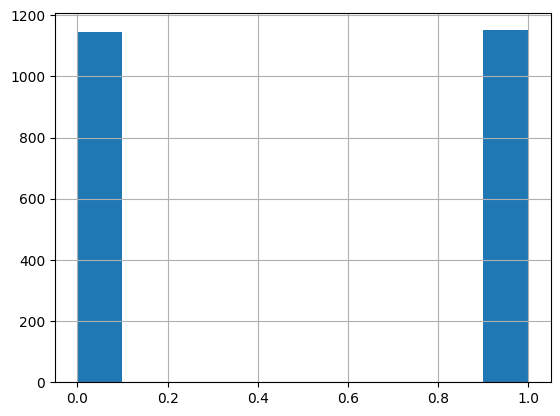

In [15]:
df_adaniports['Signal'].hist()

In [16]:
# 시계열 데이터를 LSTM 입력 형태로 변환

import numpy as np

# 시계열 데이터 생성 함수
def create_sequences(data, seq_length): # 독립변수 : Close, SEQ_LENGTH : 20(임의)
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 시계열 길이 설정
SEQ_LENGTH = 20

# 입력 데이터와 타겟 데이터 생성
X, y = create_sequences(df_adaniports[['Close']].values, SEQ_LENGTH)
y = df_adaniports['Signal'].values[SEQ_LENGTH:] # 종속변수 : Signal

# 데이터셋 분할 (훈련, 검증, 테스트)
SPLIT_RATIO = 0.8
split = int(SPLIT_RATIO * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [21]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # 매수/매도 신호 예측을 위해 sigmoid 사용

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
52/52 [==============================] - 13s 43ms/step - loss: 0.7036 - accuracy: 0.4844 - val_loss: 0.6923 - val_accuracy: 0.5246
Epoch 2/50
52/52 [==============================] - 1s 23ms/step - loss: 0.6955 - accuracy: 0.4802 - val_loss: 0.6958 - val_accuracy: 0.4754
Epoch 3/50
52/52 [==============================] - 2s 34ms/step - loss: 0.6951 - accuracy: 0.4979 - val_loss: 0.6928 - val_accuracy: 0.5246
Epoch 4/50
52/52 [==============================] - 2s 38ms/step - loss: 0.6947 - accuracy: 0.5034 - val_loss: 0.6975 - val_accuracy: 0.4754
Epoch 5/50
52/52 [==============================] - 2s 30ms/step - loss: 0.6964 - accuracy: 0.4905 - val_loss: 0.6951 - val_accuracy: 0.4754
Epoch 6/50
52/52 [==============================] - 1s 23ms/step - loss: 0.6922 - accuracy: 0.5046 - val_loss: 0.6978 - val_accuracy: 0.4754
Epoch 7/50
52/52 [==============================] - 1s 23ms/step - loss: 0.6957 - accuracy: 0.5009 - val_loss: 0.6929 - val_accuracy: 0.5246
Epoch 8/50
5

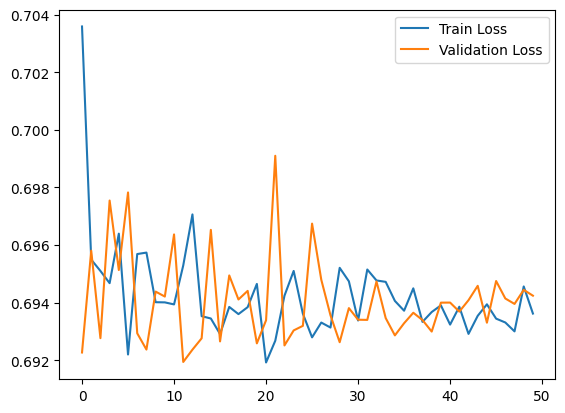

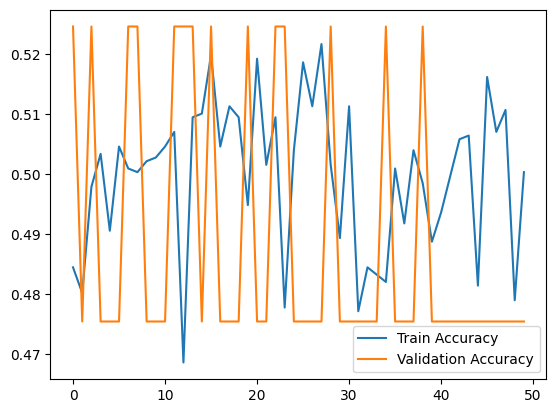

15/15 [==============================] - 0s 8ms/step - loss: 0.6938 - accuracy: 0.4868
Test Loss: 0.693810224533081, Test Accuracy: 0.4868420958518982
15/15 [==============================] - 1s 7ms/step


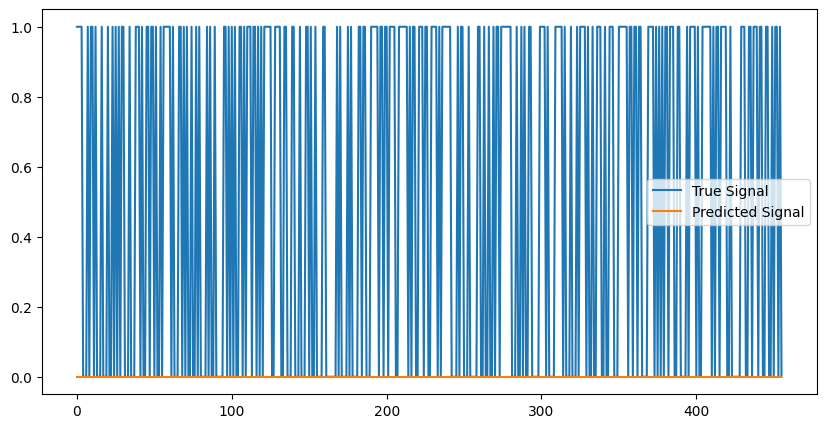

In [22]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# 학습 곡선 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 예측 수행
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Signal')
plt.plot(y_pred, label='Predicted Signal')
plt.legend()
plt.show()


### 매수 / 매도 데이터 불균형이 문제일 수 있는데, 내 데이터에서는 불균형이 아니긴 함...

### 으흐흠, 결과가 잘 안나오네
그러면, 시계열 길이, LSTM 레이어, dropout , batch_size 등을 조절하면서 모델 돌릴 수 있게 파이프라인이라도 짜보자

In [ ]:
"""
## 사용자 정의 파이프라인 구축
1. 데이터 전처리
2. 시계열 데이터 생성
3. LSTM 모델 정의 및 학습
4. 결과 시각
"""

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer


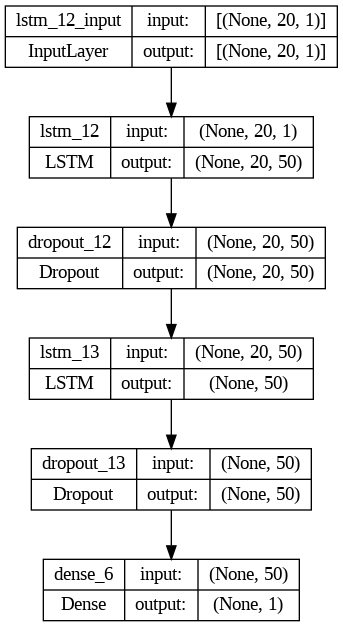

In [ ]:
"""
1. input layer : 시퀀수 길이 20, 피쳐 수 1의 형태
2. LSTM : 첫 번째 LSTM 레이어
시퀀스 길이 20, 피처 수 1의 데이터를 받아 50개의 유닛으로 구성된 LSTM 적용
return_sequences=True 옵션으로 모든 타임스텝에 대한 출력 반환
3. Dropout
드롭아웃 레이어 : 50%의 뉴런을 무작위로 드롭하여 과적합 방지
4. LSTM : 두 번째 LSTM 레이어
return_sequences=False 옵션으로 마지막 타임스텝에 대한 출력만 반환(for predict)
5. Dropout : 두 번째 드롭아웃 레이어로, 50%의 뉴런을 무작위로 드롭
6. Dense : 출력층, sigmoid 활성화 함수를 사용하여 이진 분류 문제 해결

"""

In [43]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.attribute_names].values
        else:
            return X

class CreateSequences(BaseEstimator, TransformerMixin):
    def __init__(self, seq_length):
        self.seq_length = seq_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        xs, ys = [], []
        for i in range(len(X) - self.seq_length):
            x = X[i:i+self.seq_length]
            if y is not None:
                ys.append(y[i+self.seq_length])
            xs.append(x)
        if y is not None:
            return np.array(xs), np.array(ys)
        else:
            return np.array(xs)

class LSTMModel(BaseEstimator, TransformerMixin):
    def __init__(self, seq_length=20, lstm_units=50, dropout_rate=0.2, epochs=50, batch_size=32):
        self.seq_length = seq_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        X = X.reshape(X.shape[0], X.shape[1], 1)

        self.model = Sequential()
        self.model.add(LSTM(self.lstm_units, return_sequences=True, input_shape=(self.seq_length, 1)))
        self.model.add(Dropout(self.dropout_rate))
        self.model.add(LSTM(self.lstm_units))
        self.model.add(Dropout(self.dropout_rate))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.1)
        return self

    def predict(self, X):
        X = X.reshape(X.shape[0], X.shape[1], 1)
        return (self.model.predict(X) > 0.5).astype(int)

    def evaluate(self, X, y):
        X = X.reshape(X.shape[0], X.shape[1], 1)
        return self.model.evaluate(X, y)


Epoch 1/50
55/55 [==============================] - 6s 32ms/step - loss: 0.7010 - accuracy: 0.4881 - val_loss: 0.7097 - val_accuracy: 0.4592
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 0.7039 - accuracy: 0.4807 - val_loss: 0.6911 - val_accuracy: 0.5408
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6954 - accuracy: 0.5125 - val_loss: 0.6921 - val_accuracy: 0.5408
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6988 - accuracy: 0.5085 - val_loss: 0.6921 - val_accuracy: 0.5408
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6935 - accuracy: 0.5182 - val_loss: 0.6900 - val_accuracy: 0.5408
Epoch 6/50
55/55 [==============================] - 1s 16ms/step - loss: 0.6958 - accuracy: 0.4943 - val_loss: 0.6962 - val_accuracy: 0.4592
Epoch 7/50
55/55 [==============================] - 1s 23ms/step - loss: 0.6945 - accuracy: 0.5057 - val_loss: 0.6977 - val_accuracy: 0.4592
Epoch 8/50
55

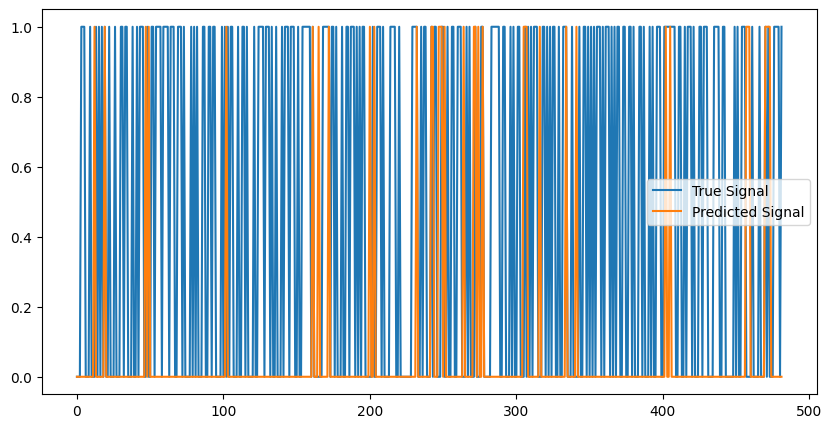

In [45]:
# 주가 데이터 로드
df = pd.read_csv('ADANIPORTS.csv')

# 필요한 열 선택 및 전처리
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['Return'] = df['Close'].pct_change()
df['Signal'] = df['Return'].apply(lambda x: 1 if x > 0 else 0)
df = df.dropna()

# 특성 선택 및 데이터셋 분할
X = df[['Close']]
y = df['Signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SEG_LENGTH = 10

# 파이프라인 정의
pipeline = Pipeline([
    ('selector', DataFrameSelector(['Close'])),
    ('scaler', FunctionTransformer(lambda x: x.reshape(-1, 1))),  # reshape to 2D for scaling
    ('standard_scaler', StandardScaler()),  # apply standard scaling
    ('reshape_back', FunctionTransformer(lambda x: x.reshape(-1, 1, 1))),  # reshape back to 3D
    ('sequences', CreateSequences(seq_length=SEG_LENGTH)),
    ('lstm', LSTMModel(seq_length=SEG_LENGTH, lstm_units=50, dropout_rate=0.2, epochs=50, batch_size=32))
])

# 데이터 전처리 및 시퀀스 생성
X_train_seq, y_train_seq = pipeline.named_steps['sequences'].transform(X_train.values, y_train.values)
X_test_seq, y_test_seq = pipeline.named_steps['sequences'].transform(X_test.values, y_test.values)

# 모델 학습
pipeline.named_steps['lstm'].fit(X_train_seq, y_train_seq)

# 모델 평가
test_loss, test_accuracy = pipeline.named_steps['lstm'].evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 예측 수행
y_pred = pipeline.named_steps['lstm'].predict(X_test_seq)

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq, label='True Signal')
plt.plot(y_pred, label='Predicted Signal')
plt.legend()
plt.show()


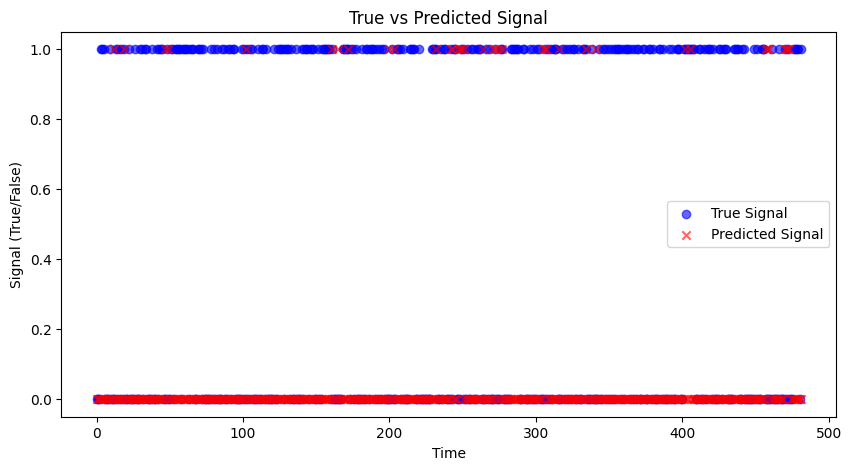

In [47]:

# 예측 결과 시각화 (True/False 형태로 변환하여 시각화)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test_seq)), y_test_seq, label='True Signal', alpha=0.6, c='blue', marker='o')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Signal', alpha=0.6, c='red', marker='x')
plt.legend()
plt.title('True vs Predicted Signal')
plt.xlabel('Time')
plt.ylabel('Signal (True/False)')
plt.show()

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn import set_config
from sklearn.utils import estimator_html_repr
from sklearn.pipeline import Pipeline
from sklearn import tree
from IPython.display import display
from sklearn import set_config

set_config(display='diagram')  # 파이프라인 시각화 설정

# 주가 데이터 로드
df = pd.read_csv('ADANIPORTS.csv')

# 필요한 열 선택 및 전처리
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['Return'] = df['Close'].pct_change()
df['Signal'] = df['Return'].apply(lambda x: 1 if x > 0 else 0)
df = df.dropna()

# 특성 선택 및 데이터셋 분할
X = df[['Close']]
y = df['Signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.attribute_names].values
        else:
            return X

class CreateSequences(BaseEstimator, TransformerMixin):
    def __init__(self, seq_length):
        self.seq_length = seq_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        xs, ys = [], []
        for i in range(len(X) - self.seq_length):
            x = X[i:i+self.seq_length]
            if y is not None:
                ys.append(y[i+self.seq_length])
            xs.append(x)
        if y is not None:
            return np.array(xs), np.array(ys)
        else:
            return np.array(xs)

class LSTMModel(BaseEstimator, TransformerMixin):
    def __init__(self, seq_length=20, lstm_units=50, dropout_rate=0.2, epochs=50, batch_size=32):
        self.seq_length = seq_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        X = X.reshape(X.shape[0], X.shape[1], 1)

        self.model = Sequential()
        self.model.add(LSTM(self.lstm_units, return_sequences=True, input_shape=(self.seq_length, 1)))
        self.model.add(Dropout(self.dropout_rate))
        self.model.add(LSTM(self.lstm_units))
        self.model.add(Dropout(self.dropout_rate))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.1)
        return self

    def predict(self, X):
        X = X.reshape(X.shape[0], X.shape[1], 1)
        return (self.model.predict(X) > 0.5).astype(int)

    def evaluate(self, X, y):
        X = X.reshape(X.shape[0], X.shape[1], 1)
        return self.model.evaluate(X, y)

# 파이프라인 정의
pipeline = Pipeline([
    ('selector', DataFrameSelector(['Close'])),
    ('scaler', FunctionTransformer(lambda x: x.reshape(-1, 1))),  # reshape to 2D for scaling
    ('standard_scaler', StandardScaler()),  # apply standard scaling
    ('reshape_back', FunctionTransformer(lambda x: x.reshape(-1, 1, 1))),  # reshape back to 3D
    ('sequences', CreateSequences(seq_length=20)),
    ('lstm', LSTMModel(seq_length=20, lstm_units=50, dropout_rate=0.2, epochs=50, batch_size=32))
])

# 파이프라인 시각화
display(pipeline)


Pipeline(steps=[('selector', DataFrameSelector(attribute_names=['Close'])),
                ('scaler',
                 FunctionTransformer(func=<function <lambda> at 0x793d0dca5b40>)),
                ('standard_scaler', StandardScaler()),
                ('reshape_back',
                 FunctionTransformer(func=<function <lambda> at 0x793d0dca6320>)),
                ('sequences', CreateSequences(seq_length=20)),
                ('lstm', LSTMModel())])

In [ ]:
"""
DataFrameSelector : 지정된 열을 선택하는 변환기 - Close 열만 선택
FunctionTransformer : 람다 함수를 사용하여 데이터를 2D 형태로 변환
StandardScaler : 데이터 표준화(각 피처의 평균을 0, 표준편차를 1로 변환)
FunctionTransformer : 데이터를 3D 형태로 변환
CreateSequences : 시퀀스를 생성하하는 변환기. 지정된 시퀀스 길이에 따라 데이터를 시퀀스로 변환
LSTMModel : LSTM 모델을 훈련하고 예측하는 변환기

"""